## Token modeling
(Jupyter Notebook 2 of 2)

#### ------ Section 4:  Create topics with latent dirichlet allocation -----------

In [249]:
import numpy as np
import pandas as pd
import re

import spacy
from spacy.lang.en import English
# nlp = spacy.load('en_core_web_md')

import nltk
from gensim.models import ldamodel

pd.set_option('max_colwidth',80)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [239]:
import NLP_Analysis
import importlib
importlib.reload(NLP_Analysis)
from NLP_Analysis import tokenize, make_dictionary
from NLP_Analysis import make_tftable, make_ldatable, classification_score

In [27]:
# Reload the cleaned up text data and relevance/positivity labels #
import pickle

with open('data/clean_articles.pkl', 'rb') as picklefile: 
    Ta = pickle.load(picklefile)
with open('data/clean_headlines.pkl', 'rb') as picklefile: 
    Th = pickle.load(picklefile)
with open('data/y_relevance.pkl', 'rb') as picklefile: 
    y_relevance = pickle.load(picklefile)
with open('data/y_positivity.pkl', 'rb') as picklefile: 
    y_positivity = pickle.load(picklefile)

In [217]:
# Split the data into training and test sets #
# Note that the articles (Ta) and headlines (Th) splits are from matching
# original documents because 'random_state' arguments are the same. Also,
# using relevance in one and positivity in the other allows both sets of
# labels to be split. (A rigorous test showed they do match up, row by
# row, after the split.)
from sklearn.model_selection import train_test_split, GridSearchCV

Ta_train, Ta_test, yr_train, yr_test = train_test_split(Ta, y_relevance, \
    test_size=0.25, stratify = y_relevance, random_state=42)
Th_train, Th_test, yp_train, yp_test = train_test_split(Th, y_positivity, \
    test_size=0.25, stratify = y_relevance, random_state=42)

yr_train[yr_train=='not sure'] = 'no'  # make the labels integers
yr_test[yr_test=='not sure'] = 'no'
yr_train = [1 if x=='yes' else 0 for x in yr_train]
yr_test = [1 if x=='yes' else 0 for x in yr_test]

In [33]:
# Create headline corpus for LDA modeling, using only training data #
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.add('%')                # percentages are handled separately

TAGS = ['NOUN','VERB','ADJ','ADV','ORG']

dict_headlines, alltokens = \
    make_dictionary(Th_train, nlp, en_stop, TAGS)
dictsize1 = len(dict_headlines)
dict_headlines.filter_extremes(no_below=3, no_above=0.8, keep_n=10000)
dictsize2 = len(dict_headlines)
print(f'Dictionary pared from {dictsize1} to {dictsize2} entries.')

corpus_headlines = [dict_headlines.doc2bow(tokens) for tokens in alltokens]
print(f'Corpus of {len(corpus_headlines)} documents created.')

500, 
1000, 
1500, 
2000, 
2500, 
3000, 
3500, 
4000, 
4500, 
5000, 
5500, 
6000, 

Dictionary pared from 7827 to 2160 entries.
Corpus of 6000 documents created.


In [71]:
# Run the LDA model over the corpus. My golly, it actually works. #
N_TOPIC = 15
lda_headlines = ldamodel.LdaModel(corpus=corpus_headlines,
        num_topics=N_TOPIC, minimum_probability=0.01,
        id2word=dict_headlines, passes=10)

lda_headlines.print_topics(num_topics=2, num_words=10)

[(2,
  '0.027*"close" + 0.027*"market" + 0.025*"seek" + 0.024*"back" + 0.023*"get" + 0.021*"review" + 0.018*"buy" + 0.018*"outlook" + 0.016*"china" + 0.015*"investor"'),
 (12,
  '0.064*"deficit" + 0.063*"trade" + 0.031*"news" + 0.026*"MONEY" + 0.020*"budget" + 0.018*"gap" + 0.016*"profits" + 0.016*"target" + 0.015*"keep" + 0.015*"export"')]

In [150]:
ldadocs_headlines = [doc for doc in lda_headlines[corpus_headlines]]
print(ldadocs_headlines[312])
print(Th_train[312])

[(0, 0.011111111), (1, 0.0111111915), (2, 0.011111111), (3, 0.011111114), (4, 0.011111111), (5, 0.46336082), (6, 0.011111122), (7, 0.011111111), (8, 0.3921946), (9, 0.011111111), (10, 0.011111115), (11, 0.011111111), (12, 0.011111122), (13, 0.011111118), (14, 0.011111113)]
Gold Rises Slightly on Bargain Interest


In [259]:
lda_headlines.print_topic(8, topn=15)

'0.027*"interest" + 0.026*"home" + 0.026*"sales" + 0.025*"see" + 0.020*"rise" + 0.019*"rates" + 0.018*"fear" + 0.017*"year" + 0.015*"house" + 0.015*"signal" + 0.013*"gain" + 0.013*"new" + 0.013*"fall" + 0.013*"inflation" + 0.013*"lead"'

In [69]:
# Repeat for article text training data #
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.add('%')                # percentages are handled separately

TAGS = ['NOUN','VERB','ADJ','ADV','ORG','GPE']  # add location entities

dict_articles, alltokens = \
    make_dictionary(Ta_train, nlp, en_stop, TAGS)
dictsize1 = len(dict_articles)
dict_articles.filter_extremes(no_below=3, no_above=0.8, keep_n=10000)
dictsize2 = len(dict_articles)
print(f'Dictionary pared from {dictsize1} to {dictsize2} entries.')

corpus_articles = [dict_articles.doc2bow(tokens) for tokens in alltokens]
print(f'Corpus of {len(corpus_articles)} documents created.')

500, 
1000, 
1500, 
2000, 
2500, 
3000, 
3500, 
4000, 
4500, 
5000, 
5500, 
6000, 

Dictionary pared from 2160 to 2160 entries.
Corpus of 6000 documents created.


In [70]:
# Run the LDA model over the corpus. My golly, it actually works. #
N_TOPIC = 15
lda_articles = ldamodel.LdaModel(corpus=corpus_articles,
        num_topics=N_TOPIC, minimum_probability=0.01,
        id2word=dict_articles, passes=10)

lda_articles.print_topics(num_topics=2, num_words=10)

In [152]:
ldadocs_articles = [doc for doc in lda_articles[corpus_articles]]
# print(ldadocs_articles[812])
# print(Ta_train[812])

In [126]:
lda_articles.print_topic(5, topn=15)

'0.016*"president" + 0.014*"say" + 0.012*"bush" + 0.008*"republican" + 0.008*"political" + 0.007*"economic" + 0.007*"campaign" + 0.006*"make" + 0.006*"state" + 0.006*"election" + 0.006*"administration" + 0.005*"party" + 0.005*"democrat" + 0.005*"democratic" + 0.005*"get"'

#### ------ Section 5:  Create classification and regression models -----------

In [153]:
# Make sparse matrix for input into classifiers and regressors. #
# Also create a dataframe version to display.
Xh_train = make_ldatable(ldadocs_headlines, N_TOPIC, sparse=True)
Xh_train_t = make_ldatable(ldadocs_headlines, N_TOPIC, sparse=False)
Xh_train_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.000000,0.000000,0.000000,0.520998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240099,0.138903,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.211230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.702103,0.000000,0.000000,0.000000,0.000000
2,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111
3,0.011111,0.531672,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.323883,0.011111,0.011111,0.011111,0.011111,0.011111
4,0.000000,0.000000,0.206367,0.000000,0.000000,0.368612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.286489,0.086152


In [154]:
# Now for articles #
Xa_train = make_ldatable(ldadocs_articles, N_TOPIC, sparse=True)
Xa_train_t = make_ldatable(ldadocs_articles, N_TOPIC, sparse=False)
Xa_train_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.000000,0.242263,0.040972,0.166047,0.0,0.000000,0.286285,0.115980,0.0,0.000000,0.000000,0.000000,0.096905,0.047282
1,0.0,0.586261,0.000000,0.000000,0.000000,0.0,0.134566,0.000000,0.000000,0.0,0.000000,0.054316,0.216021,0.000000,0.000000
2,0.0,0.000000,0.126052,0.000000,0.235027,0.0,0.000000,0.000000,0.032948,0.0,0.082622,0.000000,0.422898,0.000000,0.094000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.095469,0.000000,0.0,0.774289,0.000000,0.000000,0.114242,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.240944,0.0,0.000000,0.000000,0.213748,0.000000,0.539009


In [147]:
# First, predict classification of "relevance" labels #
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [349]:
# Find best parameters for KNN model #
model = KNeighborsClassifier()
grid_values = {'n_neighbors': [1] + list(range(2, 21, 2))}

grid_knn = GridSearchCV(model, cv=3, param_grid=grid_values, scoring='precision')
grid_knn.fit(Xa_train, yr_train);

print(grid_knn.best_estimator_)
print(grid_knn.best_params_)
print(grid_knn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')
{'n_neighbors': 6}
0.41084693787517307


In [241]:
# Find best parameters for Logistic Regression model #
# (Terrible, so move on.)
model = LogisticRegression(random_state=42, solver='newton-cg')
grid_values = {'penalty': ['l2'],'C': np.logspace(-4, 1, 6)}

grid_lr = GridSearchCV(model, cv=3, param_grid=grid_values, scoring='precision')
grid_lr.fit(Xa_train, yr_train);

print(grid_lr.best_estimator_)
print(grid_lr.best_params_)
print(grid_lr.best_score_)

/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/neuromac/anaconda3/lib/python3.6/

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
{'C': 10.0, 'penalty': 'l2'}
0.36067441330599226


In [247]:
# Find best parameters for Random Forest model #
model = RandomForestClassifier(random_state=42)
grid_values = {'n_estimators': np.array([100,250,500]),'max_features': np.linspace(0.4,0.8,3)}

grid_rf = GridSearchCV(model, cv=3, param_grid=grid_values, scoring='precision')
grid_rf.fit(Xa_train, yr_train);

print(grid_rf.best_estimator_)
print(grid_rf.best_params_)
print(grid_rf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
{'max_features': 0.4, 'n_estimators': 500}
0.41357630008525154


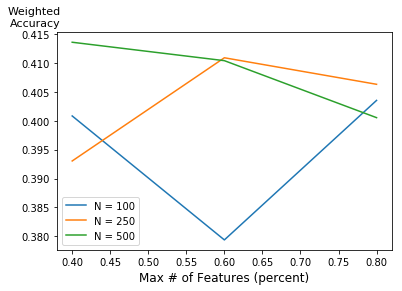

In [250]:
# Plot the results of the CV search #
cv_test_scores = grid_rf.cv_results_['mean_test_score']
cv_params = grid_rf.cv_results_['params']

xx_sm, yy_sm = [], []
xx_md, yy_md = [], []
xx_lg, yy_lg = [], []
for p,y in zip(cv_params,cv_test_scores):
    if p['n_estimators']==100:
        xx_sm.append(p['max_features'])
        yy_sm.append(y)
    elif p['n_estimators']==250:
        xx_md.append(p['max_features'])
        yy_md.append(y)
    elif p['n_estimators']==500:
        xx_lg.append(p['max_features'])
        yy_lg.append(y)

plt.plot(xx_sm,yy_sm);
plt.plot(xx_md,yy_md);
plt.plot(xx_lg,yy_lg);
plt.xlabel('Max # of Features (percent)', fontsize=12);
plt.ylabel('Weighted\nAccuracy', fontsize=11, rotation=0, ha='right');
plt.gca().yaxis.set_label_coords(0.01,1.02)
plt.legend(['N = 100','N = 250','N = 500']);

# fig = plt.gcf()
# fig.savefig('supporting_files/RF_Parameters.svg', dpi=300)

In [261]:
# Fit the LDA model to the test corpus, using the training dictionary #
_, alltokens = make_dictionary(Ta_test, nlp, en_stop, TAGS)
corpus_articles_test = [dict_articles.doc2bow(tokens) for tokens in alltokens]
# lda_articles.fit(corpus_articles_test)

ldadocs_articles_test = [doc for doc in lda_articles[corpus_articles_test]]
print(ldadocs_articles_test[812])
print(Ta_test[812])

Xa_test = make_ldatable(ldadocs_articles_test, N_TOPIC, sparse=True)

500, 
1000, 
1500, 
2000, 

[(14, 0.93777764)]
Annualized interest rates on certain investments as reported by the Federal Reserve Board on a weekly-average basis  WEEK ENDED  Jun 03, May 27, 2005 2005


In [263]:
lda_articles.print_topic(14, topn=15)

'0.034*"FED" + 0.032*"federal" + 0.029*"reserve" + 0.025*"fed" + 0.022*"bank" + 0.019*"rates" + 0.019*"interest" + 0.016*"banks" + 0.016*"say" + 0.014*"policy" + 0.013*"rate" + 0.012*"feed" + 0.010*"chairman" + 0.009*"inflation" + 0.009*"economy"'

In [251]:
# Refit the Random Forest model to the best parameters w/ all data #
model = RandomForestClassifier(n_estimators=250, max_features = 0.6,
    random_state=42)  # this one overfits, so skip it
mode = 
model.fit(Xa_train, yr_train)
ypred = model.predict(Xa_train)

classification_score(yr_train, ypred)

-- Metric ------ Value ----
 Accuracy:       1.000
 Precision:      1.000
 Recall:         1.000
 F1 Score:       1.000




In [357]:
# Same as below #
ypred_test = grid_knn.predict(Xa_test)
classification_score(yr_test, ypred_test)

-- Metric ------ Value ----
 Accuracy:       0.803
 Precision:      0.256
 Recall:         0.056
 F1 Score:       0.092




In [354]:
# Predict the test data set #
model = KNeighborsClassifier(n_neighbors=6)
model.fit(Xa_train, yr_train);
ypred_test = model.predict(Xa_test)

classification_score(yr_test, ypred_test)

-- Metric ------ Value ----
 Accuracy:       0.803
 Precision:      0.256
 Recall:         0.056
 F1 Score:       0.092




In [266]:
# Next up is regression modeling #
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [308]:
# Make reduced versions of data where 'positivity' is not NaN #
keepind = yp_train>-1   # gets around stupid numpy 64
XXa_train = Xa_train.toarray()
XXa_train = XXa_train[keepind]
yyp_train = yp_train[keepind]

keepind = yp_test>-1
XXa_test = Xa_test.toarray()
XXa_test = XXa_test[keepind]
yyp_test = yp_test[keepind]

XXa_train = np.insert(XXa_train, 0, 1, axis=1)  # add bias term
XXa_test = np.insert(XXa_test, 0, 1, axis=1)

/Users/neuromac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/neuromac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [337]:
model = sm.OLS(yyp_train, XXa_train)
fit = model.fit()
yp_pred = fit.predict(XXa_train)

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.808
Date:                Sun, 18 Nov 2018   Prob (F-statistic):           0.000263
Time:                        23:49:11   Log-Likelihood:                -2042.2
No. Observations:                1065   AIC:                             4116.
Df Residuals:                    1049   BIC:                             4196.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5261     14.525      1.895      0.058      -0.976      56.028
x1           -22.8751     14.609     -1.566      0.118     -51.541       5.791
x2           -23.1726     14.621     -1.585      0.113     -51.863       5.518
x3           -23.0948     14.615     -1.580      0.114     -51.772       5.582
x4           -22.2092     14.641     -1.517      0.130     -50.938       6.519
x5           -23.5482     14.561     -1.617      0.106     -52.119       5.023
x6           -22.1072     14.659     -1.508      0.132     -50.872       6.658
x7           -23.3376     14.612     -1.597      0.111     -52.009       5.334
x8           -22.8073     14.609     -1.561      0.119     -51.474       5.859
x9           -24.9491     14.607     -1.708      0.088     -53.611       3.713
x10          -22.2413     14.690     -1.514      0.130     -51.067       6.584
x11          -21.5390     14.615     -1.474      0.141     -50.216       7.138
x12          -22.3900     14.660     -1.527      0.127     -51.157       6.377
x13          -22.3490     14.643     -1.526      0.127     -51.082       6.384
x14          -22.1736     14.625     -1.516      0.130     -50.870       6.523
x15          -22.3604     14.608     -1.531      0.126     -51.024       6.303
==============================================================================
Omnibus:                      411.477   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.714
Skew:                           0.093   Prob(JB):                     7.98e-13
Kurtosis:                       1.895   Cond. No.                     1.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [338]:
# It's terrible. Headlines text won't be better so I'll leave it here. #
yp_pred_test = fit.predict(XXa_test)
r2 = 1 - (np.sum((yp_pred_test-yyp_test)**2) /
    np.sum((yyp_test-yyp_test.mean())**2))
print(r2)

-0.004829950899972735
